# Data Exploration to grasp how different sets of parameters and dimentions of the hypercube work together

In [45]:
from copy import copy, deepcopy
import matplotlib.pyplot as plt
import csv
import numpy as np
from dataclasses import dataclass
import pandas as pd

In [51]:
fieldnames = ["entries", "size", "dimentions", "N", "ecd_time", "ecd_size", "query_gen_time", "query_size", "query_size_no_evt_keys", "answer_gen_time", "answer_size", "answer_get_time", "online_time", "online_time_no_evt_keys", "baseline", "withTLS", "DL", "UL", "leakedBits", "informationBits"]

path = "pirGoExpTLS.csv"
path_wp = "pirGoWPTLS.csv"

all_entries = []
all_sizes = []
all_N = []
all_D = []
all_bw = []

def load_data(path):
    df = pd.read_csv(path)
    return df

In [78]:
# load data
df_pir = load_data(path)
df_wpir = load_data(path_wp)
df = pd.concat([df_pir, df_wpir])
print(df)

      entries  size  dimentions   N    ecd_time     ecd_size  query_gen_time  \
0      262144    30           3  14    0.765062     11281923        0.013210   
1      262144    30           3  14    0.765062     11281923        0.013210   
2      262144    30           3  14    0.765062     11281923        0.013210   
3      262144    30           2  14    0.892265     11280217        0.008166   
4      262144    30           2  14    0.892265     11280217        0.008166   
..        ...   ...         ...  ..         ...          ...             ...   
211  33554432  1000           3  13  131.397607  45012095582        0.001057   
212  33554432  1000           3  13  131.397607  45012095582        0.001057   
213  33554432  1000           2  13  114.146282  45011721605        0.001742   
214  33554432  1000           2  13  114.146282  45011721605        0.001742   
215  33554432  1000           2  13  114.146282  45011721605        0.001742   

     query_size  query_size_no_evt_keys

In [56]:
all_entries = df['entries'].unique()
all_sizes = df['size'].unique()
all_N = df['N'].unique()
all_D = df['dimentions'].unique()
all_bw = df["DL"].unique()

In [57]:
def filter_by_attribs(df : pd.DataFrame, attribs, values)->pd.DataFrame:
    for a,v in zip(attribs, values):
        df = df[df[a] == v]
    return df

## For a given actual db num of entries, for a given db item size, how the different combinations of BFV params and Hypercube Dimention perform? We focus on the full PIR for now

In [ ]:
@dataclass
class Performance:
    leakage : float
    online_time : float
    online_time_no_keys : float
    baseline : float
    network_cost : float
    network_cost_no_keys : float


plt.subplots_adjust(wspace=1, hspace=1.0)

bar_width = 0.3
offset = bar_width
figsize = (15, 20)  # increased figure size

for i, entries in enumerate(all_entries):
    for j, size in enumerate(all_sizes):
        # restrain to 25 Mbps
        filtered_df = filter_by_attribs(df, ["entries", "size", "DL", "leakedBits"], [entries, size, 25.0, 0.0])
        performances = {}
        for _, row in filtered_df.iterrows():
            performances[f"log(n):{row['N']}, d:{row['dimentions']}"] = Performance(
                leakage=float(row['leakedBits']) / float(row['informationBits']),
                online_time=row['online_time'],
                online_time_no_keys=row["online_time_no_evt_keys"],
                baseline=row['baseline'],
                network_cost=float(row['query_size']) + float(row['answer_size']),
                network_cost_no_keys=float(row['query_size_no_evt_keys']) + float(row['answer_size'])
            )
            
        x = np.arange(len(performances))
        leakage = [v.leakage for _, v in performances.items()]
        online_time = [v.online_time for _, v in performances.items()]
        online_time_no_keys = [v.online_time_no_keys for _, v in performances.items()]
        baseline = [v.baseline for _, v in performances.items()][0]
        network_cost = [v.network_cost / 1e6 for _, v in performances.items()]
        network_cost_no_keys = [v.network_cost_no_keys / 1e6 for _, v in performances.items()]

        num_figs = 3
        if all([v == 0.0 for v in leakage]):
            num_figs = 2

        fig, axs = plt.subplots(num_figs, figsize=figsize)
        fig.suptitle(f"Performance entries {entries}, size {size}")

        axs_i = 0
        if num_figs == 3:
            axs[axs_i].set_title("leakage")
            rects = axs[axs_i].bar(x, leakage, width=bar_width, label="leakage")
            axs[axs_i].set_xticks(x)
            axs[axs_i].set_xticklabels(performances.keys())
            axs[axs_i].bar_label(rects, padding=3)
            axs_i += 1

        axs[axs_i].set_title("Online time in log scale (s)")
        rects = axs[axs_i].bar(x, online_time, width=bar_width, label="online_time")
        axs[axs_i].bar_label(rects, padding=3)
        rects = axs[axs_i].bar(x + offset, online_time_no_keys, width=bar_width, label="online_time_no_keys")
        axs[axs_i].bar_label(rects, padding=3)
        axs[axs_i].axhline(baseline, color='green', label="TLS baseline", linestyle='dashed', lw="2")
        yticks = [*ax.get_yticks(), baseline]
        yticklabels = [*ax.get_yticklabels(), baseline]
        axs[axs_i].set_yticks(yticks, labels=yticklabels)
        #rects = axs[axs_i].bar(x + 2*offset, baseline, width=bar_width, label="TLS baseline")
        #axs[axs_i].bar_label(rects, padding=3)
        axs[axs_i].set_xticks(x)
        axs[axs_i].set_xticklabels(performances.keys())
        axs[axs_i].set_yscale('log')  # set y-axis scale to log

        axs_i += 1
        axs[axs_i].set_title("Network Cost (MB)")
        rects = axs[axs_i].bar(x, network_cost, width=bar_width, label="network_cost")
        axs[axs_i].bar_label(rects, padding=3)
        rects = axs[axs_i].bar(x + 1*offset, network_cost_no_keys, width=bar_width, label="network_cost_no_keys")
        axs[axs_i].bar_label(rects, padding=3)
        axs[axs_i].set_xticks(x)
        axs[axs_i].set_xticklabels(performances.keys())

        for ax in axs:
            ax.legend(loc='upper right', ncols=len(x))

plt.show()




### We find that logN = 13 yields better results. We analyze this results

In [244]:
QUERY_SIZE = {
    "d=2" : 8 * 2 * 1<<13,
    "d=3" : 8 * 3 * 1<<13
}

ANSWER_SIZE = 2 * 8 * 1 << 13

In [250]:
def get_time_no_keys(row):
    """ Gets expected time taking into account minimal serialization of data """
    return row["query_gen_time"] + row["answer_gen_time"] + row["answer_get_time"] + (QUERY_SIZE[f"d={int(row['dimentions'])}"] + ANSWER_SIZE)*8/(row["DL"]*1e6)

def get_network_cost_no_keys(row):
    """ Gets expected network cost taking into account minimal serialization of data """
    return QUERY_SIZE[f"d={int(row['dimentions'])}"] + round(row['answer_size']/ANSWER_SIZE)*ANSWER_SIZE

## Comparing Indexed MulPIR and Our Implementation

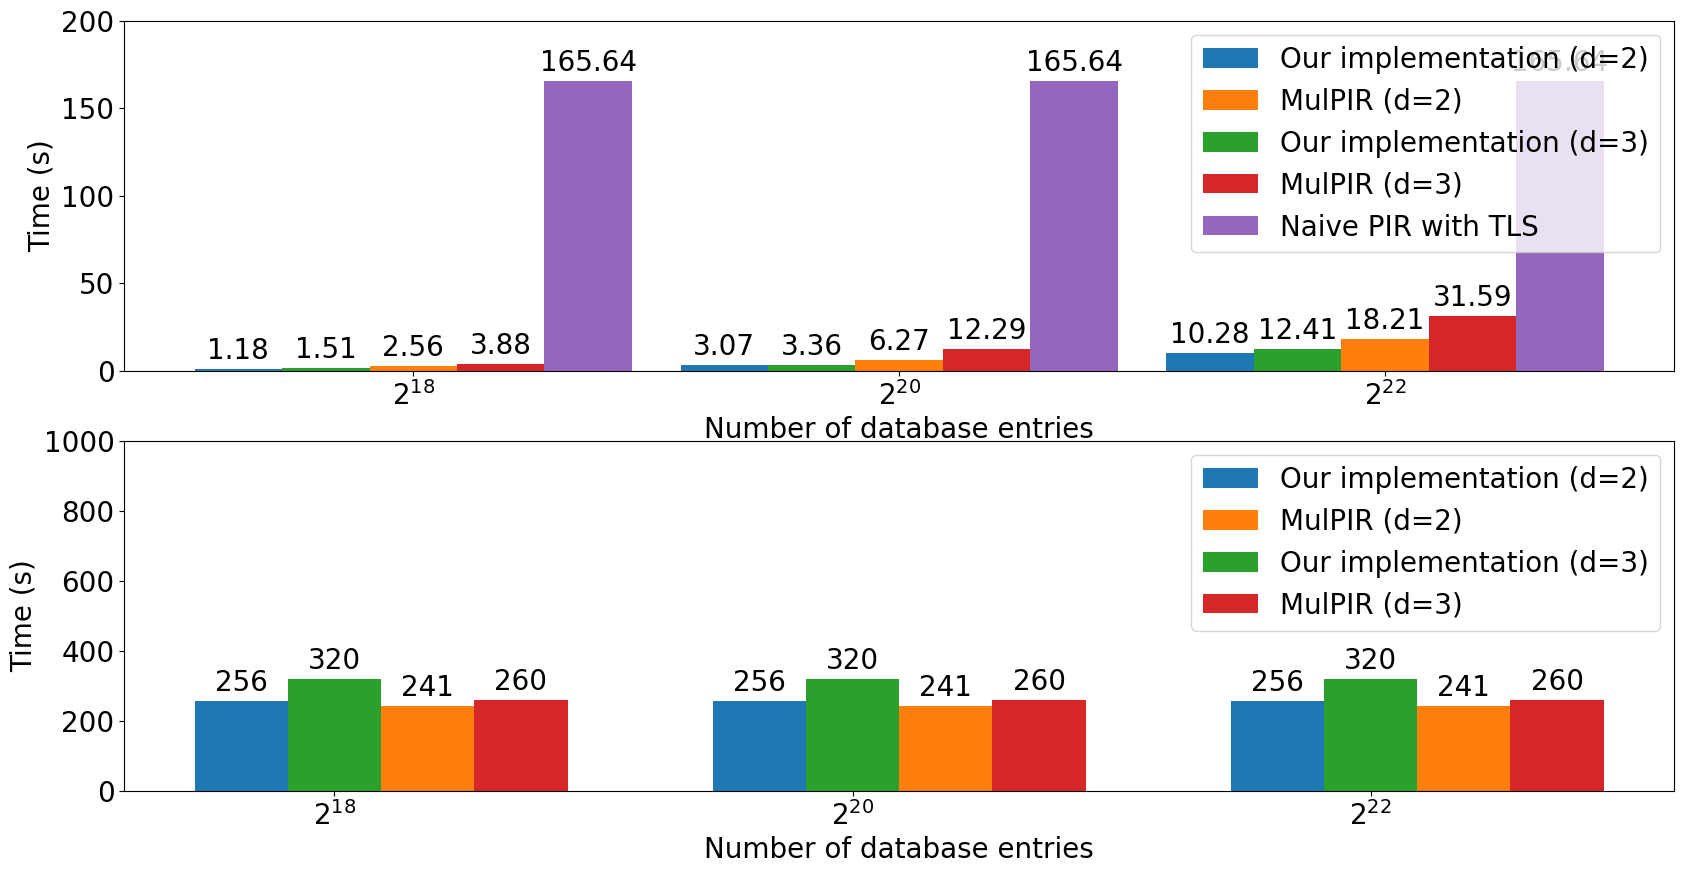

In [260]:
RELATED_WORKS = {
    "MulPIR": {
        "d=2": {
            "n=262144": {
                "time": 1919+391+172,
                "ul": 122*1024,
                "dl": 119*1024,
            },
            "n=1048576": {
                "time": 5213+783+192,
                "ul": 122*1024,
                "dl": 119*1024,
            },
            "n=4194304": {
                "time": 16307+1610+213,
                "ul": 122*1024,
                "dl": 119*1024,
            },
        },
        "d=3": {
            "n=262144": {
                "time": 126+396+3268,
                "ul": 130*1024,
                "dl": 130*1024,
            },
            "n=1048576": {
                "time": 128+395+11677,
                "ul": 130*1024,
                "dl": 130*1024,
            },
            "n=4194304": {
                "time": 30501+841+161,
                "ul": 130*1024,
                "dl": 130*1024,
            },
        },
    },
}

idx_pir_df = load_data("idxpirGoExpTLS.csv")

performances = {}
x = [1<<18, 1<<20, 1<<22]
size = 0
bw = 25.0

for d in [2,3]:
    performances[f"d={d}"] = {}
    for entries in x:
        performances[f"d={d}"][f"n={entries}"] = {}
        filtered_df = filter_by_attribs(idx_pir_df, ["entries", "dimentions","DL"], [entries, d, bw])
        for _, row in filtered_df.iterrows():
            performances[f"d={int(row['dimentions'])}"][f"n={entries}"] = Performance(
                leakage=0.0,
                network_cost=0.0,
                online_time=0.0,
                online_time_no_keys=get_time_no_keys(row),
                baseline=row['baseline'],
                network_cost_no_keys=get_network_cost_no_keys(row)
            )
            size = int(row['size'])

fig, axs = plt.subplots(2, figsize=(20,10))
X = np.arange(len(x))
bar_width = 0.18
offset = bar_width
mult_offset = -2.0

for d_idx, d in enumerate([2, 3]):
    ax = axs[0]

    # Our implementation time
    p = performances[f"d={d}"]
    time = []
    baseline = []
    for _, v in p.items():
        time.append(round(v.online_time_no_keys,2))
        baseline.append(v.baseline)

    baseline = [round(sum(baseline)/len(baseline),2) for _ in range(0, len(baseline))]
    rects = ax.bar(X + mult_offset * offset, time, width=bar_width, label=f"Our implementation (d={d})")
    ax.bar_label(rects, padding=3)

    # MulPIR time
    r = RELATED_WORKS["MulPIR"][f"d={d}"]
    time_to_compare = []
    for _, v in r.items():
        time_to_compare.append(round(v["time"] / 1000 + v["ul"] * 8 / (bw * 1e6) + v["dl"] * 8 / (bw * 1e6),2))
    rects = ax.bar(X + (mult_offset + 2) * offset, time_to_compare, width=bar_width, label=f"MulPIR (d={d})")
    ax.bar_label(rects, padding=3)

    mult_offset += 1

# Baseline time
rects = ax.bar(X + (mult_offset + 2) * offset, baseline, width=bar_width, label=f"Naive PIR with TLS")
ax.bar_label(rects, padding=3)
ax.set_xticks(X, x)
ax.set_xticklabels([f"$2^{{18}}$", f"$2^{{20}}$", f"$2^{{22}}$"])
ax.set_xlabel("Number of database entries")
ax.set_ylabel("Time (s)")
ax.set_ylim(top=200)
ax.legend()

# Second subplot: network cost performance
bar_width = 0.18
offset = bar_width
mult_offset = -1.0

for d_idx, d in enumerate([2, 3]):
    ax = axs[1]

    # Our implementation time
    p = performances[f"d={d}"]
    netw = []
    for _, v in p.items():
        netw.append(round(v.network_cost_no_keys / 1024,2))

    rects = ax.bar(X + mult_offset * offset, netw, width=bar_width, label=f"Our implementation (d={d})")
    ax.bar_label(rects, padding=3)

    # MulPIR time
    r = RELATED_WORKS["MulPIR"][f"d={d}"]
    netw_to_compare = []
    for _, v in r.items():
        netw_to_compare.append(round((v["ul"] + v["dl"])/1024,2))
    rects = ax.bar(X + (mult_offset + 2) * offset, netw_to_compare, width=bar_width, label=f"MulPIR (d={d})")
    ax.bar_label(rects, padding=3)

   

    ax.set_xticks(X, x)
    ax.set_xticklabels([f"$2^{{18}}$", f"$2^{{20}}$", f"$2^{{22}}$"])
    ax.set_xlabel("Number of database entries")
    ax.set_ylabel("Time (s)")
    ax.set_ylim(top=1000)
    ax.legend()

    mult_offset += 1

plt.show()


## Comparing Sparse-MulPIR and Our implementation

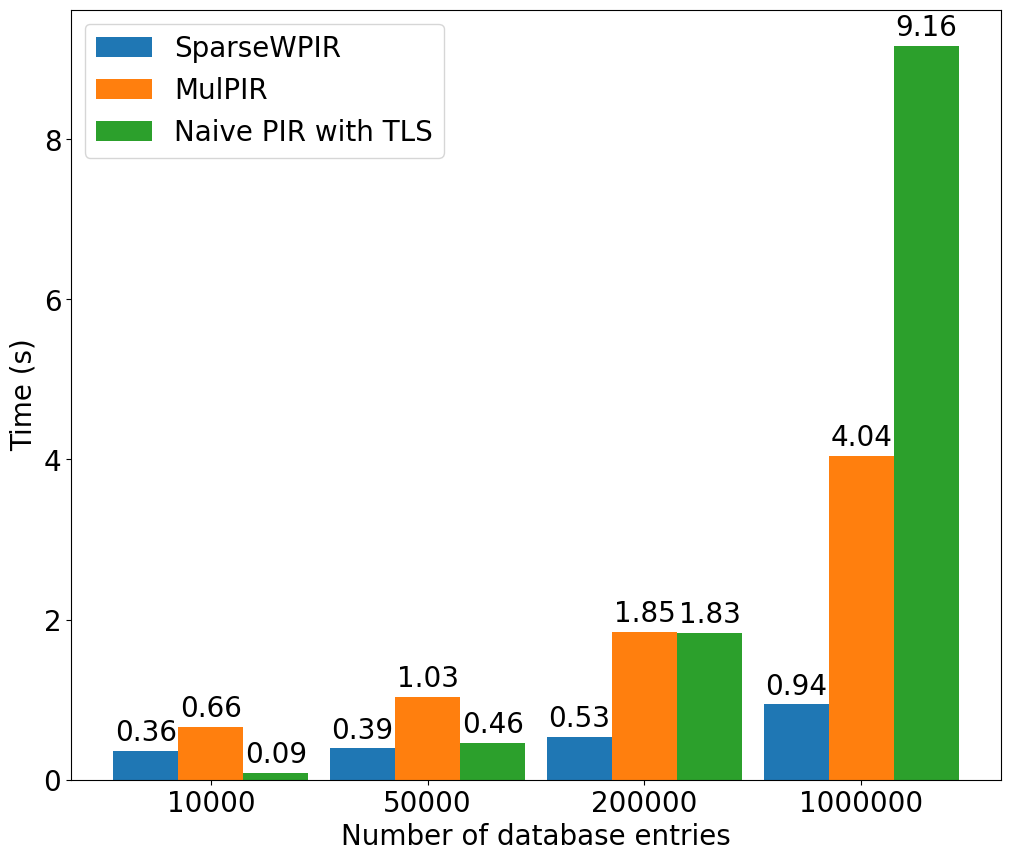

In [268]:
RELATED_WORKS = {
    "MulPIR":{
        "n=10000":{
            "time":156+475,
            "comm":90.5*1024,
            },
        "n=50000":{
            "time":195+810,
            "comm":90.5*1024,
            },
        "n=200000":{
            "time":236+1588,
          "comm":90.5*1024,
            },
        "n=1000000":{
            "time":265+3742,
            "comm":90.5*1024,
            },
    }
}

sparse_pir_df = load_data("pirGoExp_vs_mulPIR.csv")

performances = {}
x = [10*1000, 50*1000, 200*1000, 1000*1000]
size = 0
bw = 25.0
for entries in x:
    performances[f"n={entries}"] = {}
    filtered_df = filter_by_attribs(sparse_pir_df, ["entries","DL"], [entries, bw])
    for _, row in filtered_df.iterrows():
        performances[f"n={entries}"] = Performance(
            leakage=0.0,
            network_cost=0.0,
            online_time=0.0,
            online_time_no_keys=get_time_no_keys(row),
            baseline=row['baseline'],
            network_cost_no_keys=get_network_cost_no_keys(row),
        )
        size = int(row['size'])

X = np.arange(len(x))
bar_width = 0.3
offset = bar_width
mult_offset = -1.0

fig = plt.figure(figsize=(12,10))
#plt.title(f"Benchmark of Keyword-MulPIR and SparseWPIR (with no leakage)")

time = []
baseline = []
for _, v in performances.items():
    time.append(round(v.online_time_no_keys,2))
    baseline.append(round(v.baseline,2))

rects = plt.bar(X + mult_offset * offset, time, width=bar_width, label=f"SparseWPIR")
plt.bar_label(rects, padding=3)

r = RELATED_WORKS["MulPIR"]
time_to_compare = []
for _, v in r.items():
    time_to_compare.append(round(v["time"] / 1000 + v["comm"] * 8 / (bw * 1e6),2))
rects = plt.bar(X + (mult_offset + 1) * offset, time_to_compare, width=bar_width, label=f"MulPIR")
plt.bar_label(rects, padding=3)
mult_offset += 1

# Baseline time
rects = plt.bar(X + (mult_offset + 1) * offset, baseline, width=bar_width, label=f"Naive PIR with TLS")
plt.bar_label(rects, padding=3)

plt.xticks(X, x)
plt.xlabel("Number of database entries")
plt.ylabel("Time (s)")
plt.legend()

plt.show()

## Benefits of running on multiple cores

{'d=2': [16.42, 2.66, 1.71, 1.19, 2.36], 'd=3': [26.04, 4.16, 2.15, 1.45, 1.84]}


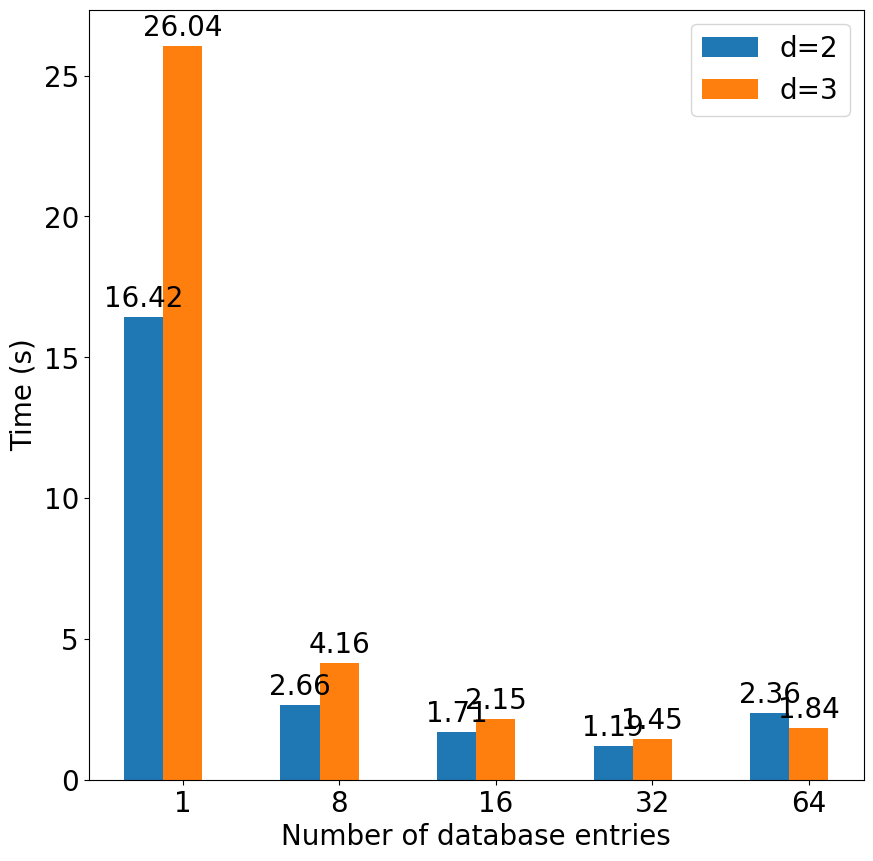

In [273]:
x = [1,8,16,32,64]
bw = 25.0
size = 0

X = np.arange(len(x))
bar_width = 0.25
offset = bar_width
mult_offset = -1.0

fig = plt.figure(figsize=(10,10))
performances = {"d=2": [], "d=3":[]}
for cores in x:
    df = load_data(f"pirGoExp_{cores}core.csv")
    for d in [2,3]:
        filtered_df = filter_by_attribs(df, ["N","dimentions", "DL"], [13, d, bw])
        for _, row in filtered_df.iterrows():
            performances[f"d={d}"].append(round(row["answer_gen_time"],2))
            size = int(row['size'])
        


#plt.title(f"Benchmark of Keyword-MulPIR and SparseWPIR (with no leakage)")

print(performances)
for d in [2,3]:
    rects = plt.bar(X + mult_offset * offset, performances[f"d={d}"], width=bar_width, label=f"d={d}")
    plt.bar_label(rects, padding=3)
    mult_offset += 1

plt.xticks(X, x)
plt.xlabel("Number of cores")
plt.ylabel("Time (s)")
plt.legend()

plt.show()